In [29]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from neo4j import GraphDatabase

In [30]:
DB_ULR = os.getenv("PAYSIM_URL")
DB_USER = os.getenv("PAYSIM_USER")
DB_PASS = os.getenv("PAYSIM_PASSWORD")
DB_NAME = os.getenv("PAYSIM_DB_NAME")
DB_ENCRYPTED = False


In [31]:
driver = GraphDatabase.driver(DB_ULR, auth=(DB_USER, DB_PASS), encrypted=DB_ENCRYPTED)

In [32]:
# Get statistics
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (t:Transaction)
        WITH sum(t.amount) AS globalSum, count(t) AS globalCnt
        WITH *, 10^3 AS scaleFactor
        UNWIND ['CashIn', 'CashOut', 'Payment', 'Debit', 'Transfer'] AS txType
        CALL apoc.cypher.run('MATCH (t:' + txType + ')
            RETURN sum(t.amount) as txAmount, count(t) AS txCnt', {})
        YIELD value
        RETURN txType,value.txAmount AS TotalMarketValue,
        100*round(scaleFactor*(toFloat(value.txAmount)/toFloat(globalSum)))
            /scaleFactor AS `%MarketValue`,
        100*round(scaleFactor*(toFloat(value.txCnt)/toFloat(globalCnt)))
            /scaleFactor AS `%MarketTransactions`,
        toInteger(toFloat(value.txAmount)/toFloat(value.txCnt)) AS AvgTransactionValue,
        value.txCnt AS NumberOfTransactions
        ORDER BY `%MarketTransactions` DESC
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,txType,TotalMarketValue,%MarketValue,%MarketTransactions,AvgTransactionValue,NumberOfTransactions
0,CashIn,2.078963e+10,43.7,46.1,139493,149037
1,CashOut,9.617113e+09,20.2,23.5,126502,76023
2,Payment,6.530112e+08,1.4,23.1,8756,74577
3,Transfer,1.647720e+10,34.6,6.0,846721,19460
4,Debit,2.580165e+07,0.1,1.4,5874,4392


In [33]:
# Find clients with flagged transactions
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client)-[]->(t:Transaction)
        WHERE t.fraud=true
        RETURN c.name, COUNT(t) AS flagged_transactions ORDER BY flagged_transactions DESC
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,flagged_transactions
0,Angel Dominguez,10
1,Nathan Stone,9
2,Sebastian Oneill,9
3,Thomas Jennings,8
4,Ethan Travis,8
...,...,...
496,Nathaniel Peterson,2
497,Ryan Russell,2
498,Kennedy Reynolds,2
499,Colton Aguirre,2


In [34]:
# Refactor/set client as fraudster if involved in flagged transaction
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WHERE size( (c)-[]->(:Transaction{fraud:true})  ) > 4
        set c.is_fraudster = 1
        return count(*) as numberOfFlaggedFraudsters
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)


,numberOfFlaggedFraudsters
0,36


In [35]:
# Inmemory projection using cypher
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.graph.create.cypher(
            'client_graph', 
            'MATCH (c:Client) return id(c) as id', 
            'MATCH (c:Client)-[:PERFORMED]->(t)-[:TO]->(c2:Client) return id(c) as source, id(c2) as target, sum(t.amount) as amount, "TRANSACTED_WITH" as type '
        )
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (c:Client) return id(c) as id,MATCH (c:Client)-[:PERFORMED]->(t)-[:TO]->(c2:...,client_graph,2433,19207,78


In [36]:
# Louvain stats
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.stats('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,0.125449,[0.12544851695872442],1,363,"{'p99': 18, 'min': 1, 'max': 24, 'mean': 6.702...",4,0,148,"{'maxIterations': 10, 'seedProperty': None, 'c..."


In [37]:
# Save louvain results
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true,
            writeProperty:'LouvainCommunity'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,49,2433,0.124143,[0.12414251955230274],1,398,"{'p99': 18, 'min': 1, 'max': 23, 'mean': 6.113...",4,0,149,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [38]:
# Find fraudlent communities ( louvain )
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WITH DISTINCT(c.LouvainCommunity) as louvain_id, count(c) as num_members
        WHERE num_members > $cap
        WITH louvain_id, num_members
        MATCH (c:Client) WHERE c.is_fraudster=1 AND c.LouvainCommunity = louvain_id
        WITH louvain_id, num_members, count(c) AS count_fraudsters
        RETURN louvain_id, num_members,count_fraudsters, toFloat(count_fraudsters)/toFloat(num_members) AS fraction_fraud
        ORDER BY fraction_fraud DESC
        """,
        cap = 10
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,louvain_id,num_members,count_fraudsters,fraction_fraud
0,94,13,2,0.153846
1,51,21,2,0.095238
2,181,11,1,0.090909
3,26,12,1,0.083333
4,65,12,1,0.083333
5,21,13,1,0.076923
6,4,16,1,0.062500


In [39]:
%%html
<iframe src="http://localhost:7474/bloom/?search=ShowCommunity%2019&perspective=FraudPerspective&run=true" width="1000" height="600"></iframe>

In [40]:
# Flag the "innocent" ( Clients in communities with few flagged transactions )
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WITH DISTINCT(c.LouvainCommunity) as louvain_id, count(c) as num_members
        WHERE num_members > 4
        WITH louvain_id, num_members
        MATCH (c:Client) WHERE c.is_fraudster=1 AND c.LouvainCommunity = louvain_id
        WITH louvain_id, num_members, count(c) AS count_fraudsters
        WITH louvain_id, num_members,count_fraudsters, toFloat(count_fraudsters)/toFloat(num_members) AS fraction_fraud
        WHERE fraction_fraud < 0.1
        MATCH (c:Client) WHERE c.LouvainCommunity=louvain_id
        SET c.is_fraudster=0
        return count(*) as numberOfFlaggedInnocent
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,numberOfFlaggedInnocent
0,85


In [41]:
# Create node embedding with FastRP
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.fastRP.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            relationshipWeightProperty:'amount',
            embeddingDimension:16, 
            writeProperty:'embedding'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2433,2433,0,4,42,"{'writeConcurrency': 4, 'normalizationStrength..."


In [42]:
# Define our model data and also get the node embeddings back to python
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE c.is_fraudster=0 OR c.is_fraudster=1
            SET c:model_data
            RETURN c.embedding as embedding, c.is_fraudster as class
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    embedding = list(df['embedding'])
    category = list(df['class'])
    

,embedding,class
0,"[0.23165281116962433, 0.3253028690814972, -0.3...",0
1,"[0.35286635160446167, -0.031428925693035126, -...",0
2,"[-0.041578274220228195, 0.013647720217704773, ...",0
3,"[0.4832615852355957, 0.02432672306895256, 0.12...",1
4,"[0.5690793991088867, 0.18987847864627838, 0.53...",0
...,...,...
109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
110,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
111,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
112,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [43]:
Y = TSNE(n_components=2, perplexity=30, n_iter= 1000, learning_rate=200.0, early_exaggeration=12.0, verbose=1).fit_transform(embedding)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 114 samples in 0.000s...
[t-SNE] Computed neighbors for 114 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 114 / 114
[t-SNE] Mean sigma: 0.653778
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.599388
[t-SNE] KL divergence after 1000 iterations: 0.586982


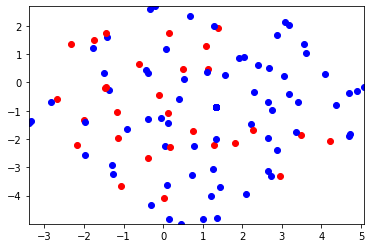

In [44]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot


for label, x, y in zip(category, x_coords, y_coords):
    if label == 0:
        plt.scatter(x, y, color='blue')
    else:
        plt.scatter(x, y, color='red')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()


In [45]:
# Calculate some additional "graph features"
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
    tx.run(
        """
        CALL gds.degree.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'degree'
        });
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
    tx.run(
        """  
        CALL gds.pageRank.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'pageRank'
        });  
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
    tx.run(
        """
        CALL gds.triangleCount.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'triangles'
        });
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodePropertiesWritten,centralityDistribution,writeMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2433,"{'p99': 44.00023651123047, 'min': 0.0, 'max': ...",4,12,0,0,"{'orientation': 'NATURAL', 'writeConcurrency':..."


,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,26,2433,20,False,"{'p99': 1.9723806381225586, 'min': 0.149999618...",6,0,21,"{'maxIterations': 20, 'writeConcurrency': 4, '..."


,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,createMillis,computeMillis,configuration
0,5,2433,550,2433,0,0,4,"{'writeConcurrency': 4, 'writeProperty': 'tria..."


In [46]:
# Calculate some additional "graph features" using cypher
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client)-[:PERFORMED]->(t:Transaction)
            WITH c, count(t) as num_transaction, sum(t.amount) as total_transaction_volume
            SET c.num_transactions=num_transaction, c.total_transaction_amnt=total_transaction_volume;
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client)-[:PERFORMED]->(t:Transaction{fraud:true})
            WITH c, count(t) as num_frauds
            SET c.num_frauds=num_frauds;
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

""


""


In [47]:
# Create projection with model data
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('fraud_graph',
            {
                Client:{
                    label:'model_data',
                    properties:{
                        embedding:{property:'embedding', defaultValue:0},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Client': {'properties': {'num_frauds': {'pro...,"{'TO': {'orientation': 'NATURAL', 'aggregation...",fraud_graph,114,0,21


In [48]:
# Train node classification & pick the best model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.train('fraud_graph', {
            nodeLabels: ['Client'],
            modelName: 'fraud-model',
            featureProperties: ['embedding', 'triangles','num_frauds','num_transactions','pageRank'], 
            targetProperty: 'is_fraudster', 
            metrics: ['F1_WEIGHTED','ACCURACY'], 
            holdoutFraction: 0.2, 
            validationFolds: 5, 
            randomSeed: 2,
            params: [
                {penalty: 0, maxEpochs: 1000},
                {penalty: 0.5, maxEpochs: 1000},
                {penalty: 1.0, maxEpochs: 1000}
                ]
                }) YIELD modelInfo
            RETURN
            modelInfo.bestParameters AS winningModel,
            modelInfo.metrics.F1_WEIGHTED.outerTrain AS trainGraphScore,
            modelInfo.metrics.F1_WEIGHTED.test AS testGraphScore
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,winningModel,trainGraphScore,testGraphScore
0,"{'maxEpochs': 1000, 'minEpochs': 1, 'penalty':...",0.463402,0.521739


In [49]:
# Label the data we want to make predictions on
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE NOT c:model_data SET c:predict_data
            return count(*)
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,count(*)
0,2319


In [50]:
# Create projection with predict_data 
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('predict_graph',
            {
                Client:{
                    label:'predict_data',
                    properties:{
                        embedding:{property:'embedding', defaultValue:0},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Client': {'properties': {'num_frauds': {'pro...,"{'TO': {'orientation': 'NATURAL', 'aggregation...",predict_graph,2319,0,33


In [51]:
# Make the predictions using node classification model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.predict.mutate('predict_graph', {
                nodeLabels: ['Client'], //filter our the character nodes
                modelName: 'fraud-model',
                mutateProperty: 'predicted_fraudster',
                predictedProbabilityProperty: 'predicted_fraud_probability'
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodePropertiesWritten,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,4638,0,0,0,1,"{'modelName': 'fraud-model', 'predictedProbabi..."


In [52]:
# Write the predictions back to the database
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.writeNodeProperties(
                'predict_graph',
                ['predicted_fraudster', 'predicted_fraud_probability'],
                ['Client']
            )
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,graphName,nodeProperties,propertiesWritten
0,63,predict_graph,"[predicted_fraud_probability, predicted_frauds...",4638


In [53]:
# What have we predicted (suspect)
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            match (c:Client) where c.predicted_fraudster = $classLabel
            return c.name, c.predicted_fraudster, 
            apoc.coll.max(c.predicted_fraud_probability) as probability, c.predicted_fraud_probability
            order by probability desc limit 10
            """,
            classLabel=1
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,c.predicted_fraudster,probability,c.predicted_fraud_probability
0,Mackenzie Monroe,1,0.780777,"[0.21922295146394294, 0.7807770485360567]"
1,Gabriella Terrell,1,0.772058,"[0.2279424745167298, 0.7720575254832698]"
2,Brooklyn Peters,1,0.755037,"[0.24496296704918374, 0.7550370329508158]"
3,Matthew Goodman,1,0.721250,"[0.2787500408904123, 0.7212499591095872]"
4,Brayden Wise,1,0.654502,"[0.3454976001040924, 0.6545023998959072]"
5,Blake Phelps,1,0.652654,"[0.3473461138586689, 0.6526538861413306]"
6,Alexander Stevens,1,0.636191,"[0.36380945414516663, 0.6361905458548329]"
7,Jackson Chapman,1,0.634937,"[0.36506315961582486, 0.6349368403841745]"
8,Caleb Calhoun,1,0.616541,"[0.38345917270536806, 0.6165408272946316]"
9,Andrew Cooper,1,0.616325,"[0.38367477023318153, 0.616325229766818]"


In [54]:
# What have we predicted
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            match (c:Client) where c.predicted_fraudster = $classLabel
            return c.name, c.predicted_fraudster, 
            apoc.coll.max(c.predicted_fraud_probability) as probability, c.predicted_fraud_probability
            order by probability desc limit 10
            """,
            classLabel=0
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,c.predicted_fraudster,probability,c.predicted_fraud_probability
0,Blake Mccray,0,0.998404,"[0.9984042310735006, 0.0015957689264993879]"
1,Evelyn Craig,0,0.998274,"[0.9982739398667455, 0.0017260601332545825]"
2,Nolan Duffy,0,0.998057,"[0.9980569887825489, 0.0019430112174511854]"
3,Ellie Crawford,0,0.996013,"[0.9960130324758275, 0.003986967524172403]"
4,Grayson Cortez,0,0.995172,"[0.9951718634613683, 0.004828136538631593]"
5,Joseph Petersen,0,0.994958,"[0.9949576664969266, 0.005042333503073187]"
6,London Sharp,0,0.994910,"[0.9949104948274898, 0.005089505172510007]"
7,London Goff,0,0.994731,"[0.9947310219251202, 0.005268978074879621]"
8,Brody Cantu,0,0.994623,"[0.9946229539407881, 0.005377046059211647]"
9,Sarah Washington,0,0.994573,"[0.9945733409931352, 0.0054266590068646455]"


In [55]:
# Clean up gds graph and model catalogue 
with driver.session(database = DB_NAME) as session:
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.beta.model.drop('fraud-model')").consume()
        )
    except:
        print()
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('client_graph')").consume()
        )
    except:
        print()
    try: 
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('fraud_graph')").consume()
        )
    except:
        print()
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('predict_graph')").consume()  
        )
    except:
        print()

In [56]:
# Clean up temporary labels and properties
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction(lambda tx: 
        tx.run("MATCH (c:model_data) remove c:model_data").consume()
    )
    result = session.write_transaction(lambda tx: 
        tx.run("MATCH (c:predict_data) remove c:predict_data").consume()
    )
    result = session.write_transaction(lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        remove  c.predicted_fraudster, 
                c.predicted_fraud_probability,
                c.embedding,
                c.is_fraudster,
                c:model_data,
                c:predict_data
        """).consume()
    )